In [1]:
# Geometric optics 
# Script to verify ray propagation with
# matrix vector operations.
# Light rays are represented as a vector [tan(theta) h 1]^T
# where theta is the incidence angle and h the height from the
# optical axis.
# The analysis is in 2D as we exploit symmetry.
# The code below simulates ray tracing in a light field camera.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# main lens
f1 = 30e-3; # focal length
D = 3e-2; # diameter

# microlens array
N = 5; # 2N+1 lenses
f2 = .5e-3; # focal length
d = D/(2*N+1); # diameter

Delta1 = 60e-3;  # distance main lens to microlens
Delta2 = 0.5e-3; # distance microlens to image plane (focused)
#Delta2 = 0.6e-3; # distance microlens to image plane (defocused)

# sensor
M = 100; # pixels
mu = D/M; # pixel size (we assume that the sensor is as large as the main lens)
img = np.zeros((M,1));

# 3D point (use only Y and Z)
P = np.array([0, 1e-2, -1])
V1 = np.array([1, -P[2], 0]).reshape(3,1);
V2 = np.array([0, P[1], 1]).reshape(3,1);

theta = np.linspace(-np.pi/2,np.pi/2,100000);
tant = np.tan(theta);
# main lens aperture
valid = np.logical_and(tant<(D/2-P[1]/(-P[2])), tant>-(D/2+P[1])/(-P[2]))
tantheta = tant[valid];

In [4]:
ML1 = np.array([[1, -1/f1, 0],
                    [0, 1, 0],
                    [0, 0, 1]])
MS1 = np.array([[1, 0, 0],
                   [Delta1, 1, 0],
                   [0, 0, 1]])

In [5]:
V1

array([[1.],
       [1.],
       [0.]])

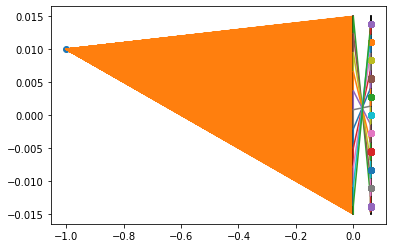

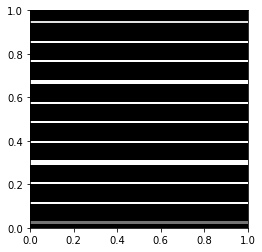

In [10]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 1, 1)
fig2 = plt.figure()
ax2 = fig2.add_subplot(1, 1, 1)

ax1.plot(P[2], P[1], 'o')
ax1.plot(np.concatenate((P[2]*np.ones((tantheta.shape[0], 1)), np.zeros((tantheta.shape[0], 1))), 1).flatten(),
         np.concatenate((P[1]*np.ones((tantheta.shape[0], 1)), -P[2]*np.expand_dims(tantheta, 1)+P[1]), 1).flatten())

#plot([P(3)*ones(size(tantheta))' zeros(size(tantheta))']',[P(2)*ones(size(tantheta))' -P(3)*tantheta'+P(2)]');

# # draw main lens
ax1.plot([0, 0], [-D/2, D/2], 'k')
# draw image plane
ax1.plot([Delta1+Delta2, Delta1+Delta2], [-D/2, D/2], 'k')

for j in range(-N, N+1):
    b = d * j
    ML1 = np.array([[1, -1/f1, 0],
                    [0, 1, 0],
                    [0, 0, 1]])
    MS1 = np.array([[1, 0, 0],
                   [Delta1, 1, 0],
                   [0, 0, 1]])
    W1 = MS1 @ ML1 @ V1
    W2 = MS1 @ ML1 @ V2
    
    ML2 = np.array([[1, -1/f2, b/f2],
                    [0, 1, 0],
                    [0, 0, 1]])
    MS2 = np.array([[1, 0, 0],
                    [Delta2, 1, 0],
                    [0, 0, 1]])
    
    W3 = MS2 @ ML2 @ MS1 @ ML1 @ V1
    W4 = MS2 @ ML2 @ MS1 @ ML1 @ V2
    
    Mall = MS2 @ ML2 @ MS1 @ ML1
    F1 = Mall @ V1
    F2 = Mall @ V2
    # check aperture microlens
    valid = np.abs((Delta1-P[2] * (1-Delta1/f1)) * tantheta+ P[1]*(1-Delta1/f1)-b) < d/2
    output = F1 * tantheta[valid] + F2 * np.ones((1, np.sum(valid)))
    
    # build output image (a line of pixels) via sparse matrices so each ray
    # contribution can be accumulated efficiently
    rows = np.round(output[1,:]/D*M) + M/2 + 1 # quantization of the incident rays on the pixel locations
    cols = np.zeros_like(rows)
    vals = np.sum(valid) / np.size(valid)*np.ones_like(rows)
    img_ = np.zeros((M, 1))
    img_[rows.astype(np.int), cols.astype(np.int)] = vals
    img = img + img_
    
    ax2.imshow(img, extent=[0, 1, 0, 1], cmap='gray')
    
    # draw ray path step by step
    # draw microlens
    ax1.plot([Delta1, Delta1], [d*j-d/2, d*j+d/2], 'k')
    # draw rays from main lens to microlens
    ax1.plot(np.concatenate((np.zeros(valid.sum()), Delta1 * np.ones(valid.sum()))),
             np.concatenate((-P[2] * tantheta[valid] + P[1], W1[1]*tantheta[valid] + W2[1])))
    # draw final rays onto image plane
    ax1.plot(np.concatenate((Delta1 * np.ones(valid.sum()), (Delta1+Delta2)*np.ones(valid.sum()))),
             np.concatenate((W1[1] * tantheta[valid] + W2[1], W3[1]*tantheta[valid] + W4[1])))
    # show hit pixels
    ax1.plot((Delta1+Delta2)*np.ones((output.shape[1])), output[1,:], 'o')
#     plt.pause(1)

In [8]:
W1 = MS1@ML1@V1

In [ ]:
W1[1]

In [ ]:
%debug

In [ ]:
np.numel(5)

In [ ]:
figure(1)
clf
hold on
plot(P(3),P(2),'o');
plot([P(3)*ones(size(tantheta))' zeros(size(tantheta))']',[P(2)*ones(size(tantheta))' -P(3)*tantheta'+P(2)]');
% draw main lens
plot([0 0],[-D/2 D/2],'k')
% draw image plane
plot([Delta1+Delta2 Delta1+Delta2],[-D/2 D/2],'k')
%axis equal
%axis([-Delta1 Delta1+2*Delta2 -D/2 D/2])
for j=-N:N
    b = d*j; % microlens height
    ML1 = [1 -1/f1 0; 0 1 0; 0 0 1];
    MS1 = [1 0 0; Delta1 1 0; 0 0 1];
    W1 = MS1*ML1*V1; W2 = MS1*ML1*V2;

    ML2 = [1 -1/f2 b/f2; 0 1 0; 0 0 1];
    MS2 = [1 0 0; Delta2 1 0; 0 0 1];
    
    W3 = MS2*ML2*MS1*ML1*V1; W4 = MS2*ML2*MS1*ML1*V2;
    
    Mall = MS2*ML2*MS1*ML1;
    F1 = Mall*V1;
    F2 = Mall*V2;
    % check aperture microlens
    valid = abs((Delta1-P(3)*(1-Delta1/f1))*tantheta+P(2)*(1-Delta1/f1)-b)<d/2;
    output = F1*tantheta(valid)+F2*ones(1,sum(valid));
    % build output image (a line of pixels) via sparse matrices so each ray
    % contribution can be accumulated efficiently
    rows = round(output(2,:)/D*M)+M/2+1; % quantization of the incident rays on the pixel locations
    cols = ones(size(rows));
    vals = sum(valid)/numel(valid)*ones(size(rows));
    img = img+sparse(rows,cols,vals,M,1);
    figure(2)
    imagesc(img);
    colormap gray(256)
    drawnow;
    figure(1)
    
    % draw ray path step by step
    % draw microlens
    plot([Delta1 Delta1],[d*j-d/2 d*j+d/2],'k')
    % draw rays from main lens to microlens
    plot([zeros(size(tantheta(valid)))' Delta1*ones(size(tantheta(valid)))']',...
         [-P(3)*tantheta(valid)'+P(2) W1(2)*tantheta(valid)'+W2(2)]');
    % draw final rays onto image plane
    plot([Delta1*ones(size(tantheta(valid)))' (Delta1+Delta2)*ones(size(tantheta(valid)))']',...
         [W1(2)*tantheta(valid)'+W2(2) W3(2)*tantheta(valid)'+W4(2) ]');
    % show hit pixels
    plot((Delta1+Delta2)*ones(1,size(output,2)),output(2,:),'o');
    drawnow
    pause
    
end
hold off